In [210]:
# Note: If you are having trouble loading Spark, try uncommenting the following two lines
#import findspark
#findspark.init()
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame

import numpy as np
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Function loads a food data text file and separates each row into (key, value) pair
# Input: fileName: 'location/of/file.csv'
#        delimiter: 'delimiter string', default='\t'
# Return: [('key', 'header'), ('data', 'header')], RDD <<(key, value), (key, value), ...>>
def loadParkingData(fileName, delimiter=','):
    # Load data values
    csv_data = sc.textFile(fileName)
    split_data = csv_data.map(lambda x: x.split(delimiter))
    
    # Separate header from data
    header = split_data.first()
    data = split_data.filter(lambda x: x!=header)
    
    
#     Fill missing values with marker values (i.e., np.nan)
    missing_data = data.map(lambda x: [x[i] if x[i]!='' else np.nan for i in range (0,7)])
    
    # Map the data to (key, value) pairs
    kv_data = missing_data.map(lambda x: [x[0],x[1], x[2],x[3],x[4],x[5],x[6]])
    kv_header = [header[0], header[1], header[2],header[3],header[4],header[5], header[6] ] # Match header to kv_data
    
    return kv_header, kv_data


# Load the data in the first file
header, data = loadParkingData('s.csv')

# Look at the column names and the first row of data
print(header)
print(data.collect()[:][1])

['Violation Code', 'Violation Precinct', 'Registration State', 'Vehicle Make', 'Violation Time', 'Violation County', 'Vehicle Color']
['71', '23', 'NY', 'HONDA', '0724P', 'NY', nan]


# Make a DataFrame

# Remove Rows with Missing Values

# From 6744 to 6508 (Data Reduced)

In [223]:
table = data.collect()
df = DataFrame (table)
# df = df.transpose()
df.columns = header
df.dropna(inplace = True)
# print (df)

In [224]:
def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2


In [225]:
data = df.values.T.tolist()


# Making RDD from Each Lists

In [240]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local").setAppName("DataCount")
sc = SparkContext.getOrCreate(conf=conf)
# header, data = loadFoodData('s.csv')
violation_code = sc.parallelize(data[0])
violation_precinct = sc.parallelize(data[1])
registration_state = sc.parallelize(data[2])
vehicle_make = sc.parallelize(data[3])
violation_time = sc.parallelize(data[4])
violation_county = sc.parallelize(data[5])
vehicle_color = sc.parallelize(data[6])


# print (violation_code.collect())

# Count of Violation Code

In [229]:
vio_code_count = violation_code.map(makeKeyValue)
vio_code_sum = vio_code_count.reduceByKey(addValues)

vio_code_counts_sorted = sorted (vio_code_sum.collect(), key = lambda x: x[1], reverse = True)

print('Violation Code :  Count')
for vio_code, count in vio_code_counts_sorted[:6]:
    print('{:<11}    : {:>6}'.format(vio_code, count))
    

Violation Code :  Count
71             :   1441
7              :   1083
14             :    550
21             :    543
20             :    463
40             :    394


<Figure size 432x288 with 0 Axes>

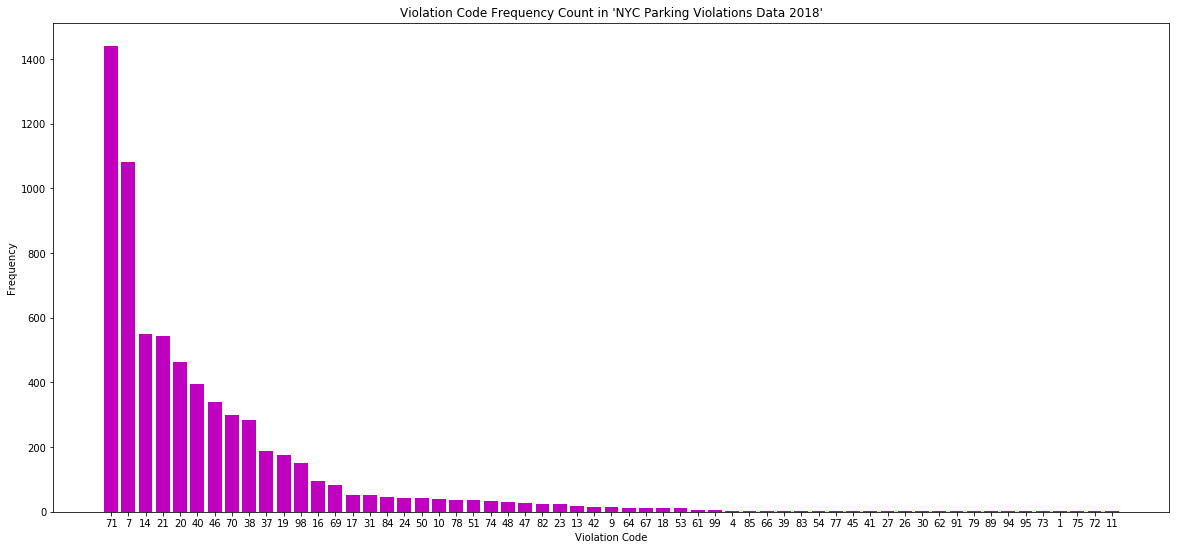

In [230]:
plt.clf()

vio_code_counts_sorted = sorted (vio_code_sum.collect(), key = lambda x: x[1], reverse = True)
# print (vio_code_counts_sorted)
fig, axs = plt.subplots(1,1,figsize=(20,9))

X_vals, Y_vals = zip(*vio_code_counts_sorted)

x = [x for x, _ in enumerate(X_vals)]
# axs.bar(X_vals, Y_vals, 0.75)
# plt.xlim((.125, len(X_vals)))

axs.bar(x, Y_vals, color='m')

plt.xticks(x, X_vals)
plt.xlabel('Violation Code')
plt.ylabel('Frequency')
plt.title("Violation Code Frequency Count in 'NYC Parking Violations Data 2018'")
plt.show()

# Count of Violation Time

In [231]:
violation_time_count = violation_time.map(makeKeyValue)
violation_time_sum = violation_time_count.reduceByKey(addValues)

vio_time_counts_sorted = sorted (violation_time_sum.collect(), key = lambda x: x[1], reverse = True)

print('Violation Time          :  Count')
for vio_time, count in vio_time_counts_sorted[:20]:
    print('{:<20}    : {:>6}'.format(vio_time, count))
        

Violation Time          :  Count
0133P                   :     26
1146A                   :     25
0143P                   :     24
1136A                   :     23
0124P                   :     23
1215P                   :     22
0118P                   :     22
0110P                   :     21
1108A                   :     21
1143A                   :     21
1209P                   :     21
1255P                   :     20
1130A                   :     20
1201P                   :     20
0135P                   :     20
0155P                   :     20
1139A                   :     20
1116A                   :     19
0157P                   :     19
0120P                   :     19


# 20 most common violation time

<Figure size 432x288 with 0 Axes>

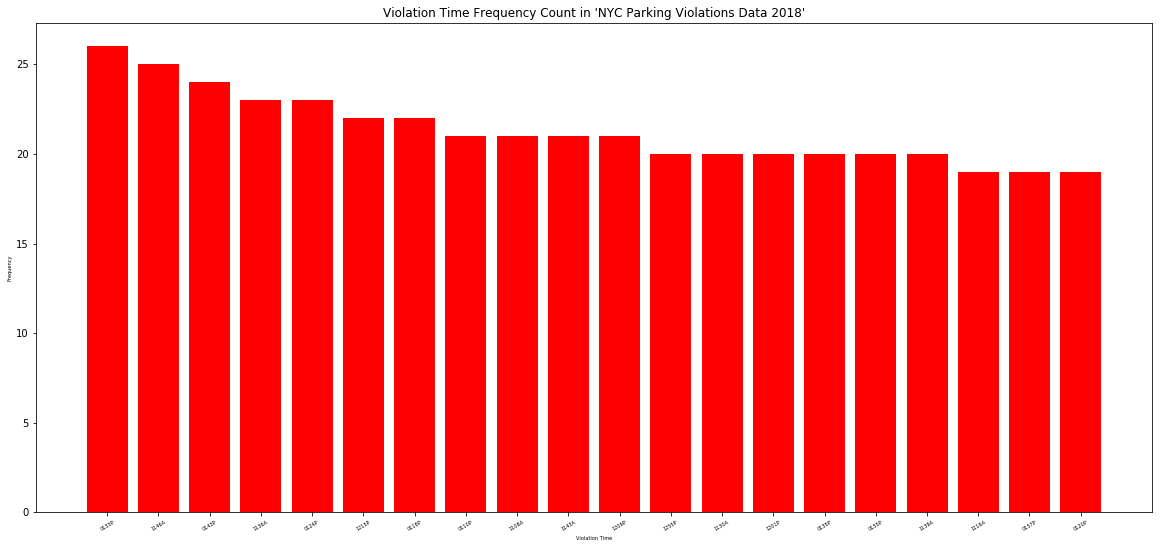

In [247]:
plt.clf()

vio_time_counts_sorted = sorted (violation_time_sum.collect(), key = lambda x: x[1], reverse = True)

X_vals, Y_vals = zip(*vio_time_counts_sorted[:20])

def plot_bar(x,y,x_label,y_label,title):
    fig, axs = plt.subplots(1,1,figsize=(20,9))
    index = np.arange(len(x))
    plt.bar(index, y, color ='r')
    plt.xlabel(x_label, fontsize=5)
    plt.ylabel(y_label, fontsize=5)
    plt.xticks(index, x, fontsize=5, rotation=30)
    plt.title(title)
    plt.show()
    
    
plot_bar (X_vals, Y_vals, "Violation Time", "Frequency", "Violation Time Frequency Count in 'NYC Parking Violations Data 2018'"  )

# x = [x for x, _ in enumerate(X_vals)]
# # axs.bar(X_vals, Y_vals, 0.75)
# # plt.xlim((.125, len(X_vals)))

# axs.barh(x, Y_vals, color='r')

# plt.yticks(x, X_vals)
# plt.ylabel('Violation Time')
# plt.xlabel('Frequency')
# plt.title("Violation Time Frequency Count in 'NYC Parking Violations Data 2018'")
# plt.show()

# Count of Violation Vehicle Body Type

In [241]:
vehicle_make_count = vehicle_make.map(makeKeyValue)
vehicle_make_sum = vehicle_make_count.reduceByKey(addValues)

vehicle_make_counts_sorted = sorted (vehicle_make_sum.collect(), key = lambda x: x[1], reverse = True)
# print (vehicle_make_counts_sorted)
print('Vehicle Make            :  Count')
for vehicle_make, count in vehicle_make_counts_sorted[:10]:
    print('{:<20}    : {:>6}'.format(vehicle_make, count))
    
ls = [vehicle_make for vehicle_make, count in vehicle_make_counts_sorted[:]]
    
print ("Total Number of Vehicle Body Type: ", len(ls))

Vehicle Make            :  Count
TOYOT                   :    981
FORD                    :    787
HONDA                   :    710
NISSA                   :    566
CHEVR                   :    433
FRUEH                   :    256
ME/BE                   :    251
DODGE                   :    224
BMW                     :    210
JEEP                    :    204
Total Number of Vehicle Body Type:  81


<Figure size 432x288 with 0 Axes>

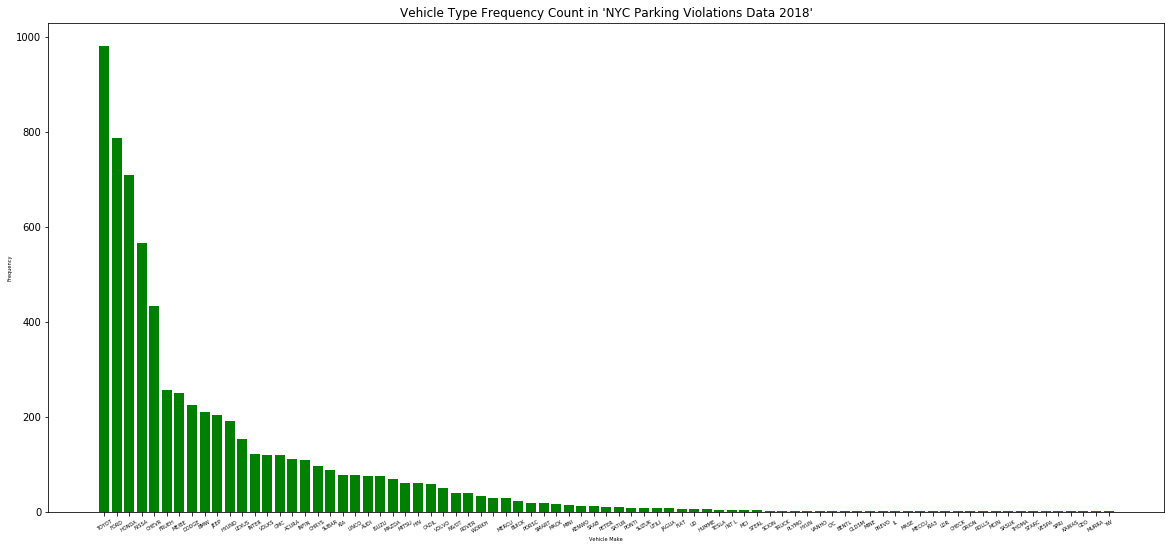

In [243]:
plt.clf()

vehicle_make_counts_sorted = sorted (vehicle_make_sum.collect(), key = lambda x: x[1], reverse = True)

# fig, axs = plt.subplots(1,1,figsize=(20,9))

X_vals, Y_vals = zip(*vehicle_make_counts_sorted)


# this function can be called to plot bargarphs

def plot_bar(x,y,x_label,y_label,title):
    fig, axs = plt.subplots(1,1,figsize=(20,9))
    index = np.arange(len(x))
    plt.bar(index, y, color ='g')
    plt.xlabel(x_label, fontsize=5)
    plt.ylabel(y_label, fontsize=5)
    plt.xticks(index, x, fontsize=5, rotation=30)
    plt.title(title)
    plt.show()
    
# x = [x for x, _ in enumerate(X_vals)]
# axs.bar(X_vals, Y_vals, 0.75)
# plt.xlim((.125, len(X_vals)))

# axs.bar(x, Y_vals, color='m')

# plt.xticks(x, X_vals)
# plt.xlabel('Vehicle Make')
# plt.ylabel('Frequency')
# plt.title("Vehicle Type Frequency Count in 'NYC Parking Violations Data 2018'")
# plt.show()


plot_bar (X_vals, Y_vals,"Vehicle Make","Frequency", "Vehicle Type Frequency Count in 'NYC Parking Violations Data 2018'" )